
<h1>Data Mining & Foundations of AI (Assessment 1)</h1>


Does tesla stock records reflect the existence of common percieved market trends, and is Teslas stock history suggesting a history of growth?

---



<h2>Introduction</h2>

In 2023, Tesla quickyl became the second fastest growing company on the planet. (Fortune.com, 2023)

For this EDA, we will utilise the data behind Tesla's stock values to find out if they reflect various percieved market trends, such as the 'January Effect', which states that the value of most companies jumps in January (investopedia.com, 2024).

The file I used for this is:


*   tsla_raw_data.csv

Using an EDA with this file, I intend to draw conclusions using both a Random Forest based machine learning model, and a regression model. But before that, I will describe the file I intend to use:

<h2>Tesla Raw Data</h2>

The columns in this dataset are:

*   Date (The date of the data taken)
*   Open (The value of the stock when the markets opened)
*   High (The highest value the stock was during the day)
*   Low (The lowest value the stock was during the day)
*   Close (The value of the stock when the markets closed)
*   Volume (The number of shares traded)
*   Adjusted_Close (The closing price after adjustments for all applicable splits and dividend distributions)
*   Change_Percent (How much the stock value changed in percentages)
*   Avg_Vol_20d (The value of the last 20 days of stocks summed)

---

First, lets import our libraries:





In [1]:
import os
import calendar

import numpy
import pandas
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import spearmanr
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

data = pandas.read_csv('/content/drive/MyDrive/tsla_raw_data.csv')
data.set_index('date', inplace=True)
data.index = pandas.to_datetime(data.index, dayfirst = True)

<ipython-input-1-afc818298415>:21: UserWarning: Parsing dates in %Y-%m-%d format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data.index = pandas.to_datetime(data.index, dayfirst = True)


---

Now, lets view the basic information:

In [2]:
data.head()

,open,high,low,close,volume,adjusted_close,change_percent,avg_vol_20d
date,,,,,,,,
2010-06-29,18.9999,24.9999,17.5401,23.8899,18783278,1.5927,NaN,NaN
2010-06-30,25.7901,30.4191,23.3001,23.8299,17194392,1.5887,-0.25,NaN
2010-07-01,24.9999,25.9200,20.2701,21.9600,8229862,1.4640,-7.85,NaN
2010-07-02,23.0001,23.1000,18.7101,19.2000,5141806,1.2800,-12.57,NaN
2010-07-06,20.0001,20.0001,15.8301,16.1100,6879295,1.0740,-16.09,NaN


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3448 entries, 2010-06-29 to 2024-03-11
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            3448 non-null   float64
 1   high            3448 non-null   float64
 2   low             3448 non-null   float64
 3   close           3448 non-null   float64
 4   volume          3448 non-null   int64  
 5   adjusted_close  3448 non-null   float64
 6   change_percent  3447 non-null   float64
 7   avg_vol_20d     3429 non-null   float64
dtypes: float64(7), int64(1)
memory usage: 242.4 KB


This shows that we have 3448 entires overall, and 8 columns. However, 2 columns contain non-null values. These are:



*   change_percent
*   avg_vol_20d

We will be setting these values to 0. This is because the missing values are only because you could not calculate the data yet (Change from the first day, or average over 20 days respectively).



In [4]:
#Swap NaN for 0, to prevent errors
data['change_percent'] = data['change_percent'].fillna(0)
data['avg_vol_20d'] = data['avg_vol_20d'].fillna(0)


In [5]:
print(data['close'].describe())

count    3448.000000
mean      306.673902
std       290.053098
min        15.800100
25%       151.150050
50%       234.225000
75%       337.057425
max      2238.750000
Name: close, dtype: float64


From this, we can already find some interesting conclusions, such as the minimum close value being 15.8, and the maximum being 2238.75.

---

# Pre-Processing



# **Scatterplot - Comparing Change % to Price**

---



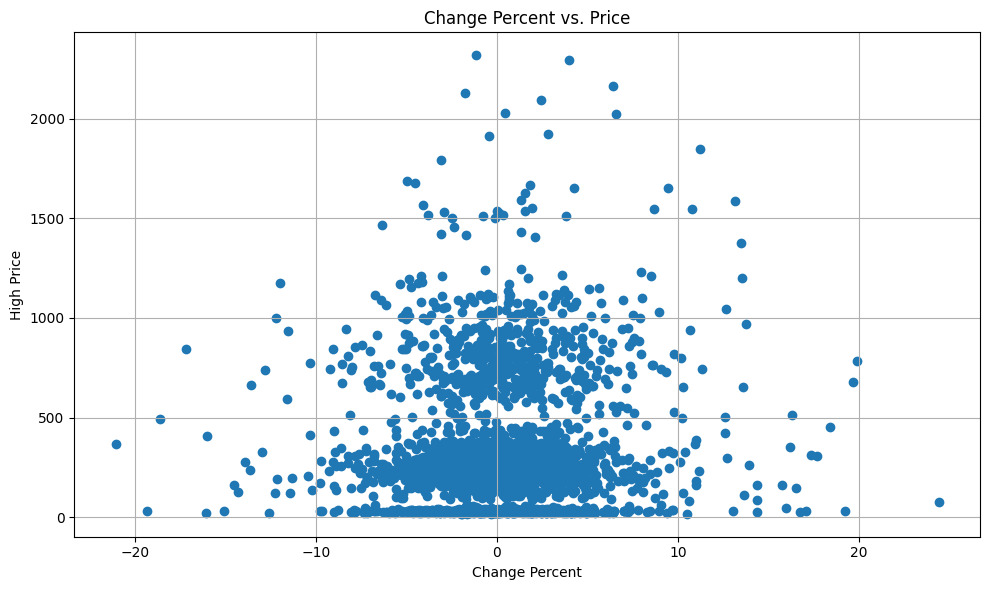

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(data['change_percent'], data['high'])
plt.title('Change Percent vs. Price')
plt.xlabel('Change Percent')
plt.ylabel('High Price')
plt.grid(True)
plt.tight_layout()
plt.show()

What this graph tells us is that there are a few significant outliers in the data, which may severely skew our data analysis. This must be fixed.

To remove outliers, I have found any value outs the 1.5x IQR below the 25th or above the 75th percentiles of the volume value. (AnalyticsVidhya, 2024) This is because the extremeist outliers can skew my calculated averages unfairly, which would harm our future anaysis.

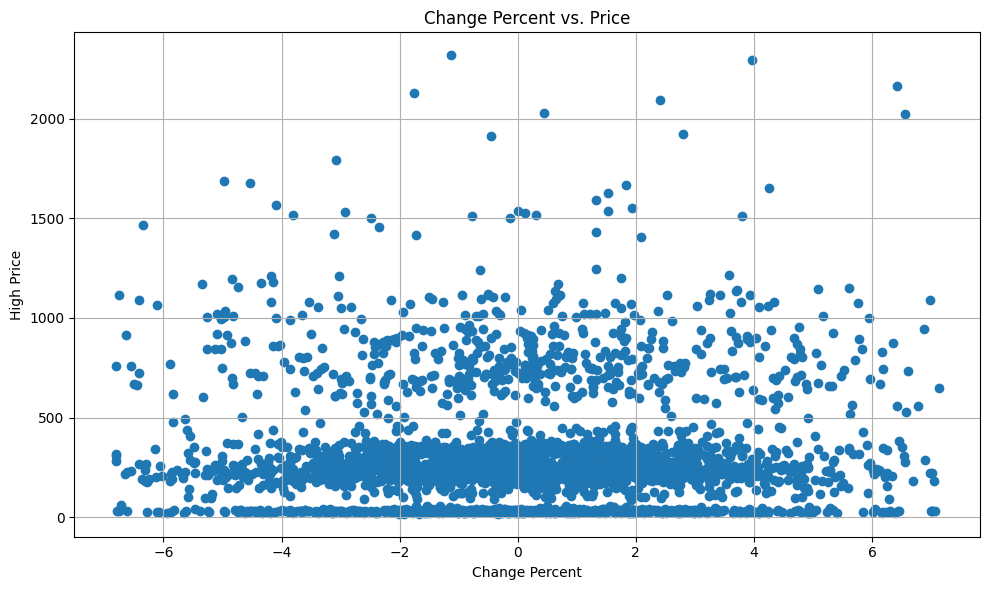

In [7]:
Q1 = data['change_percent'].quantile(0.25)
Q3 = data['change_percent'].quantile(0.75)
IQR = Q3 - Q1

# identify outliers
threshold = 1.5
outliers = data[(data['change_percent'] < Q1 - threshold * IQR) | (data['change_percent'] > Q3 + threshold * IQR)]

data = data.drop(outliers.index)

plt.figure(figsize=(10, 6))
plt.scatter(data['change_percent'], data['high'])
plt.title('Change Percent vs. Price')
plt.xlabel('Change Percent')
plt.ylabel('High Price')
plt.grid(True)
plt.tight_layout()
plt.show()

This updated graph displays the outliers remove, giving us a much more even dataset for further analysis.

---



# Exploratory Data Analysis

# **Bar Chart - Average High Value by Month**


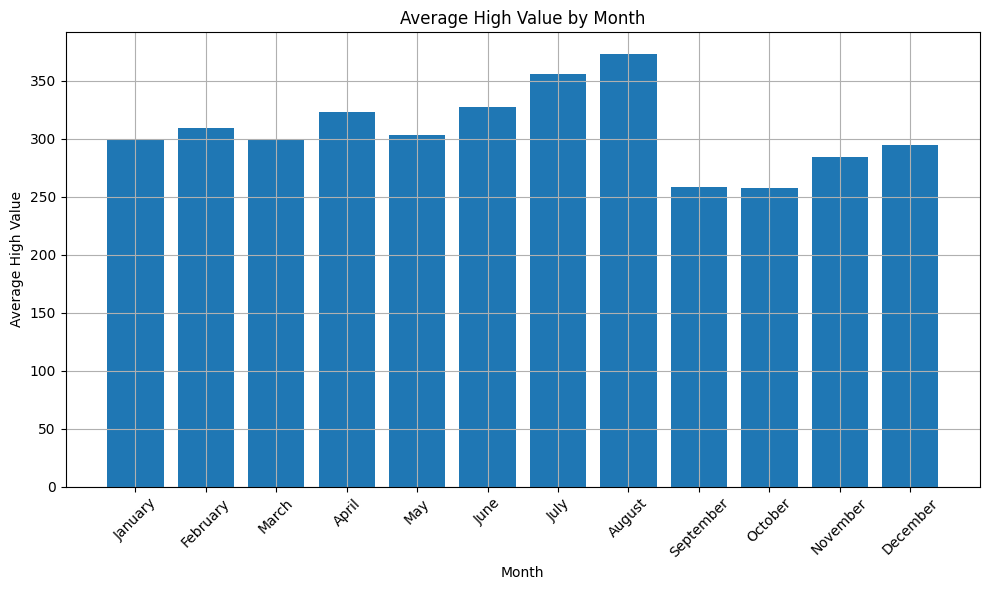

In [8]:
# Calculating the average change percent per month
monthly_avg_open = data['high'].groupby(data.index.month).mean()

month_names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(month_names, monthly_avg_open)
plt.title('Average High Value by Month')
plt.xlabel('Month')
plt.ylabel('Average High Value')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

# **Bar Chart Conclusions**

From this, I can see a stark example of the september effect. This is an observed pattern in the markets in which rates of return from investment are  significantly lower than the months preceeding it. (BRIGroup, 2023) You can also note how it recovers during the rest of the year, to almost match the January value.

---


# **Line Graph - Volume vs High Value**

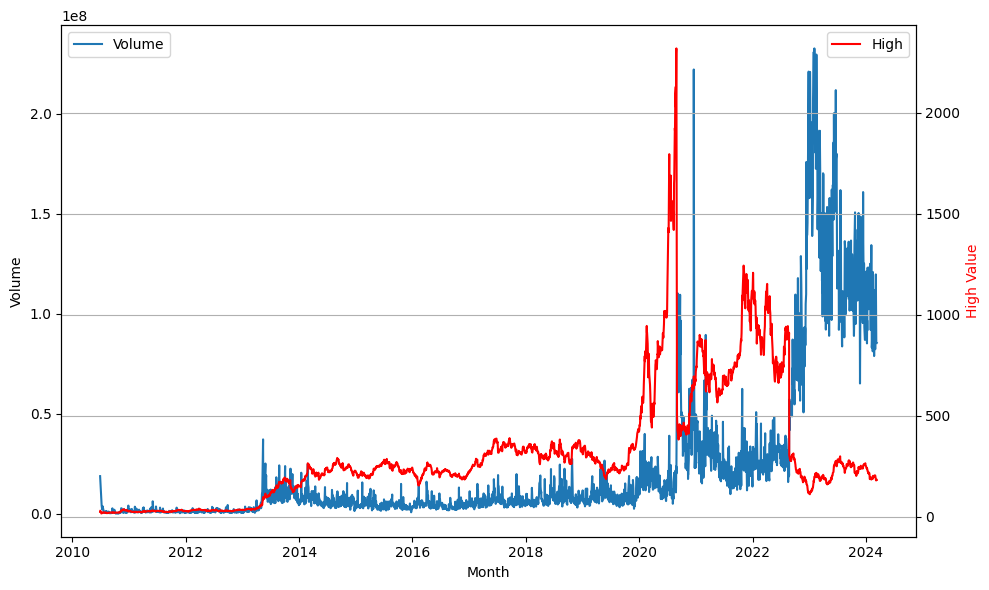

In [9]:
# Calculating the average change percent per month
volume = data['volume']
high = data['high']

# Plotting
fig, cx1 = plt.subplots(figsize=(10, 6))
cx1.plot(data.index, volume)
cx1.set_xlabel('Month')
cx1.set_ylabel('Volume')
cx2 = cx1.twinx()
cx2.plot(data.index, high, color='red')
cx2.set_ylabel('High Value', color='red')
plt.grid(True)
plt.tight_layout()
# Add a legend
cx1.legend(['Volume'], loc='upper left')
cx2.legend(['High'], loc='upper right')
plt.show()

# **Line Graph Conclusions**

From this, you can observe a we can observe positive correlations between different parameters such as the value of the stock and volume of stocks traded - When the value peaked in late 2021, a significant amount of stocks were (persumably) sold, and equally bought when the value tanked in late 2022. We can analyse this suspected correlation further using the Pearson and Spearman correlation formulas.

---

# **Correlation Analysis - Volume vs High Value**

In [10]:
# Calculate spearman's correlation
corr, _ = pearsonr(data['high'], data['volume'])
print('Pearsons correlation: %.3f' % corr)

# Calculate spearman's correlation
corr, _ = spearmanr(data['high'], data['volume'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.075
Spearmans correlation: 0.604


# Correlation Analysis Conclusion

But first, what are these correlations?

* The Pearson correlation measures the *linear* relationship between two variables
* The Spearman correlation measures the monotonic relationship between two variables. (Minitab, 2024)

From this analysis we find:



*   Pearsons correlation has a value of 0.075. This would at most suggest an incredibly small positive correlation between values, however more realistically theres isnt much of a correlation in this measurement.
*   Spearmans correlation has a value of 0.604. This suggests a strong monotonic relation between the two values - that is, when one changes the other does as well.

Whilst the Pearson result is shaky, the Spearman result clearly shows a relationship between the volume of stocks transacted, and the value of the stock as a whole.

---

# **Histogram - Change Percent by Volume Quartiles**

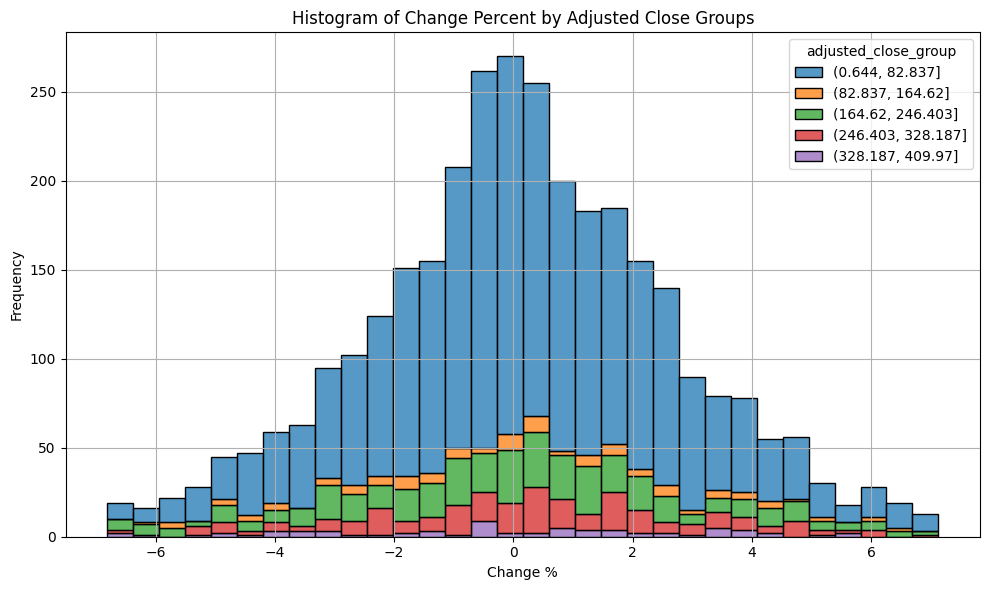

In [11]:
data['adjusted_close_group'] = pandas.cut(data['adjusted_close'], bins=5)

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='change_percent', hue='adjusted_close_group', multiple='stack')
plt.xlabel('Change %')
plt.ylabel('Frequency')
plt.title('Histogram of Change Percent by Adjusted Close Groups')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Histogram Conclusions**

This graph provides us with a few interesting insights. First of all, the data is in a 'normal' distribution, telling us that the stock is overall pretty stable, most often changing by fractions of a percent. Also, low adjusted prices are the most common. This tells us that the number of shares is increasing as a trend, with a decreasing price in individual shares.

---

# **Correlation Analysis - Change Percent vs Adjusted Close**

In [12]:
# Calculate spearman's correlation
corr, _ = pearsonr(data['change_percent'], data['adjusted_close'])
print('Pearsons correlation: %.3f' % corr)

# Calculate spearman's correlation
corr, _ = spearmanr(data['change_percent'], data['adjusted_close'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: -0.004
Spearmans correlation: 0.013


# Correlation Analysis Conclusion

From this analysis we find:



*   Pearsons correlation has a value of -0.004. This suggests essentially no correlation between values.
*   Spearmans correlation has a value of 0.013. This suggests a incredibly weak monotonic relation between the two values - that is, when one changes the other usually does not.

These results tell us the price of the stock, in the grand scheme of things, does not really correlate with its recent change percentage. Whilst a few outliers may slightly effect our results, be it large increases or decreases in value, it cannot tell us about wider trends.

---

# **Histogram - Distribution of Open Prices with KDE**

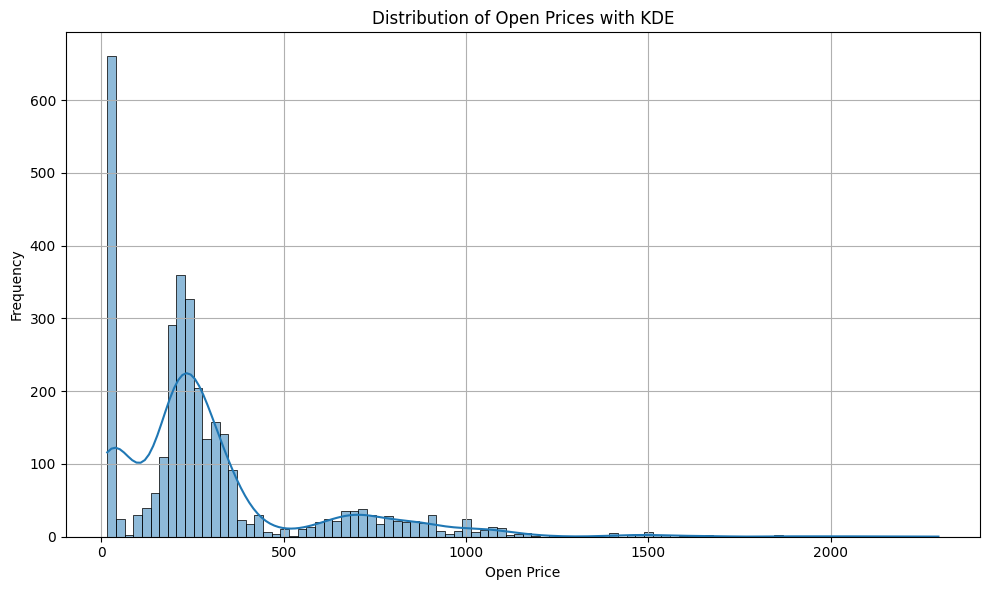

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(data['open'], kde=True)
plt.xlabel('Open Price')
plt.ylabel('Frequency')
plt.title('Distribution of Open Prices with KDE')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Histogram Conclusions**

This graph also provides us with a few insights. First of all, the data is in a significantly right skewed (positive) distribution. This informs us that there is an incredibly common open price a little above 0, that comes up quite often in our data. A consistent open price would suggest that Tesla has a relatively stable market value - very little fluctuation, but also no growth. This was undeniably true until about 2019, which explains the much smaller quantity of high cost open prices. It is a historically irrelevant company.

---

# **Scatter Plot - High vs Low**

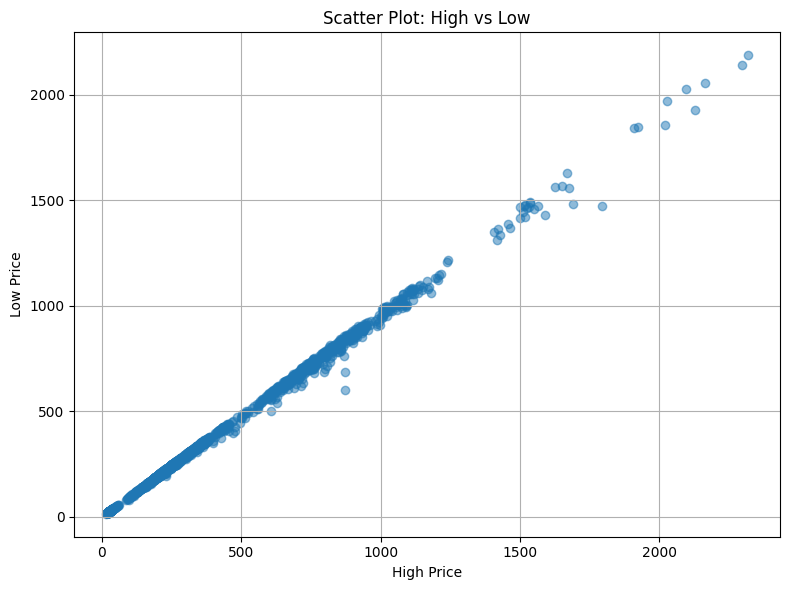

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(data['high'], data['low'], alpha=0.5)
plt.xlabel('High Price')
plt.ylabel('Low Price')
plt.title('Scatter Plot: High vs Low')
plt.grid(True)
plt.tight_layout()
plt.show()

# **Scatter Plot Conclusions**

I realise a scatter plot with these two variables is a slightly strange combination to pick, but I believe we can still learn from it.  Namely, that the low price is almost always incredibly similar to the high price. This tells us that on the day-to-day, the price of the stock is not very volatile. However, as the overall price has increased, the gap between the high and low prices has also increased somewhat, suggesting increased volatility. You can clearly see a strong positive correlation on the graph, which I will now confirm with a correlation analysis.

---

# **Correlation Analysis - High vs low**

In [15]:
# Calculate spearman's correlation
corr, _ = pearsonr(data['high'], data['low'])
print('Pearsons correlation: %.3f' % corr)

# Calculate spearman's correlation
corr, _ = spearmanr(data['high'], data['low'])
print('Spearmans correlation: %.3f' % corr)

Pearsons correlation: 0.999
Spearmans correlation: 0.999


# Correlation Analysis Conclusion

From this analysis we find:



*   Pearsons correlation has a value of 0.999. This suggests an incredibly strong and positive correlation between values.
*   Spearmans correlation has a value of 0.999. This suggests a incredibly storng monotonic relation between the two values.

These results do not surprise me. They tell us that both the maximum and minimum value of a stock change at pretty equal rates - there are no sudden liquidations in which people want money fast and sell below market value, etc.

---

# **Pair Plot**

In [ ]:
# Selecting columns for pair plot
pair_columns = ['open', 'high', 'low', 'close', 'volume', 'adjusted_close']

# Plotting Pair Plot
plt.figure(figsize=(12, 8))
sns.pairplot(data[pair_columns])
plt.suptitle('Pairwise Relationships between Numerical Variables')
plt.tight_layout()
plt.show()

# **Pair Plot Conclusions**

Just for fun, lets end it off with a pair plot. This will let us see how various bits of data correlate, and spot any outliers. As you can see, its mostly all very very correlative and uniform. However, you may not the volume seems to have a distinct outlier in most of its comparisons, around when a high volume of stock existed but it was clearly treated differently. This may be a fluctuation due to poor news coverage, etc. Despite this, it overall displays many of the basic market trends as being present in teslas history - sudden rises in price, explosive volume increase, and so on.

---

# **Decision Tree Implementation**

In [ ]:
X = data[['open', 'high', 'low', 'volume', 'adjusted_close']]
y = data['change_percent'] > 0  # Binary classification: 1 if stock price increased, 0 otherwise

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
dt_preds = dt_model.predict(X_test)
rf_preds = rf_model.predict(X_test)

# Accuracy
dt_accuracy = accuracy_score(y_test, dt_preds)
rf_accuracy = accuracy_score(y_test, rf_preds)

print("Decision Tree Accuracy:", dt_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# **Decision Tree & Random Forest Conclusions**

* **Decision tree:** The accuracy for the decision tree was 0.677. This indicated that the model is easily able to detect patterns in the data set and predict the correct outcomes.

* **Random Forest:** Our random forest is an equally impressive 0.698. This high stat further proves that the model is appropriate to predict the change percent based on the we fed to it.

In conclusion, these are both very strong indicators that the model is able to find patterns data which will allow it to predict if the price of a stock has changed based upon other values in the system. This may be invaluable in analysis and understanding market trends and seeing if tesla reflects them.

---

# **Linear Regression**

In [ ]:
X = data[['open', 'high', 'low', 'volume']]
y = data['close']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predictions
lr_preds = lr_model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, lr_preds)
r2 = r2_score(y_test, lr_preds)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# **Linear Regression Conclusions**

* **Mean squared error:** Our MSE has a value of just 35.6. This indicated there is little difference between the values predicted by the model, and the actual values in the dataset. This would suggest that it is a suitable model for further use.

* **R Squared:** Our R^2 value is a staggering 0.999. This high stat further stresses to us that the model is appropriate to predict the chosen data stat (this time the close value). It is able to more easily explain variabilities in the data.

In conclusion, These results show me that the data is perfect for training the model, with great accuracy and performance. The incredibly high value r^2 value initially made me suspicous, but with the model using the high, low, and volume, it makes sense that it can pretty easily predict what the closing value should be.



---



---

# **References**

* Fortune.com (2023) On 2023’s 100 Fastest-Growing Companies list, Tesla makes its debut, the financial sector’s reign ends, and industrials take off. Available at: https://fortune.com/2023/10/25/fastest-growing-companies-2023-tesla-financials-industrials/. (Accessed: March 15, 2024).
* investopedia.com (2024) January Effect: What It Is in the Stock Market, Possible Causes https://www.investopedia.com/terms/j/januaryeffect.asp
* AnalyticsVidhya.com (2024) Outlier Detection & Removal | How to Detect & Remove Outliers https://www.analyticsvidhya.com
* BRIGroup (2023) The 'September Effect' https://brigroup.co.uk/the-september-effect/
* Minitab (2024) A comparison of the Pearson and Spearman correlation methods https://support.minitab.com/en-us/minitab/help-and-how-to/statistics/basic-statistics/supporting-topics/correlation-and-covariance/a-comparison-of-the-pearson-and-spearman-correlation-methods/